In [190]:
%load_ext autoreload
%autoreload 2

from dfa import Dfa
from model import SequenceModel, Ngram, GaussianProbe
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from torch import nn, optim
import torch

N_STATES = 8
N_SYMBOLS = 32
N_ADJACENCIES = 4

N_ITERS = 2000

def train_model(dfa, rand, train, **train_params):
    return SequenceModel.train_model(dfa, rand, 256, 256, max_iters=(N_ITERS if train else 0), model_type="transformer", **train_params)

def train_ngram_model(dfa, rand, max_order):
    return Ngram.train_model(dfa, rand, max_order, n_samples=64 * 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
def compute_interpolator(contexts, true_label, pred_labels):
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.params = nn.ParameterList([nn.Parameter(torch.tensor(0).float().cuda()) for _ in pred_labels])
            self.loss = nn.MSELoss(reduction="none")
        
        def forward(self, true_dist, pred_dists):
            param_sum = sum([torch.exp(p) for p in self.params])
            params_norm = [torch.exp(p) / param_sum for p in self.params]
            pred = [param * dist for param, dist in zip(params_norm, pred_dists)]
            pred = sum(pred)
            loss = self.loss(pred, true_dist).sum(dim=1).mean(dim=0)
            err = torch.abs(pred - true_dist).sum(dim=1).mean(dim=0) / 2
            return loss, err
        
    model = Model()
    opt = optim.Adam(model.parameters(), lr=0.01)
    true_data = torch.tensor([contexts[k][true_label] for k in contexts]).float().cuda()
    pred_data = [torch.tensor([contexts[k][pred_label] for k in contexts]).float().cuda() for pred_label in pred_labels]
    for i in range(200):
        loss, err = model(true_data, pred_data)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return err.item(), [p.item() for p in model.params]

def run_experiment_1(dfa, data_rand, hypotheses, **train_params):
    rnn = train_model(dfa, data_rand, train=True, **train_params)
    rnn_copy = train_model(dfa, data_rand, train=True, **train_params)
    ngram = None
    if any("gram" in name for name, _ in hypotheses):
        ngram = train_ngram_model(dfa, data_rand, max_order=2)
    
    ghost_symbols = []
    real_symbols = []
    while len(ghost_symbols) < 100:
        prefix = dfa.sample(data_rand)
        if len(prefix) == 0:
            continue
        prefix_len = data_rand.randint(len(prefix))
        prefix_symbols = prefix[:prefix_len]
        ann = dfa.annotate(prefix_symbols)
        prefix_state = ann[-1]
        edges = dfa.edges[prefix_state]
        
        forbidden_symbols = [sym for sym, dst in edges] + dfa.unused_symbols
        ghost_choices = [i for i in range(dfa.n_symbols) if i not in forbidden_symbols]
        if len(ghost_choices) == 0:
            continue
        ghost_symbol = data_rand.choice(ghost_choices)
        ghost_symbols.append(prefix_symbols + (ghost_symbol,))
        
        real_choices = [sym for sym, dst in edges if sym is not None]
        real_symbol = data_rand.choice(real_choices)
        real_symbols.append(prefix_symbols + (real_symbol,))
        dfa.annotate(prefix_symbols + (real_symbol,))
        
        #ghost_symbols.append(prefix_symbols + (real_symbol,))
    
    results = []
    ghost_contexts = defaultdict(dict)
    real_contexts = defaultdict(dict)
    for hypothesis_name, hypothesis in hypotheses:
        total_interp_dist = 0
        total_extrap_dist = 0
        count = 0
        for i in range(len(real_symbols)):
            rs = real_symbols[i]
            true_states = dfa.annotate(rs, allow_incomplete=True)
            if rs in real_contexts:
                true_preds = real_contexts[rs]["TRUE"]
                copy_preds = real_contexts[rs]["COPY"]
            else:
                true_preds, = rnn.predict_one([rs])
                copy_preds, = rnn_copy.predict_one([rs])
                real_contexts[rs]["TRUE"] = true_preds
                real_contexts[rs]["COPY"] = copy_preds
            real_preds = hypothesis(
                dfa, rs, true_states,
                model_preds=true_preds, copy_preds=copy_preds, ngram_model=ngram,
                **train_params
            )
            gt = dfa.predict_one(true_states[-1])

            #print(np.abs(true_preds - real_preds).sum() / 2)
            #print(np.abs(true_preds - gt).sum() / 2)
            #if np.abs(true_preds - gt).sum() / 2 > .5:
                #print(gt[:20])
                #print(true_preds[:20])
                #print(copy_preds[:20])
                #print(real_preds[:20])
                #print(rs)
                #assert False
            real_contexts[rs][hypothesis_name.strip()] = real_preds
            total_interp_dist += np.abs(true_preds - real_preds).sum() / 2
            
            # -----
            
            gs = ghost_symbols[i]
            true_states = dfa.annotate(gs[:-1], allow_incomplete=True)
            if gs in ghost_contexts:
                true_preds = ghost_contexts[gs]["TRUE"]
                copy_preds = ghost_contexts[gs]["COPY"]
            else:
                true_preds, = rnn.predict_one([gs])
                copy_preds, = rnn_copy.predict_one([gs])
                ghost_contexts[gs]["TRUE"] = true_preds
                ghost_contexts[gs]["COPY"] = copy_preds
            
            ghost_preds = hypothesis(
                dfa, gs, true_states, 
                model_preds=true_preds, copy_preds=copy_preds, ngram_model=ngram,
                **train_params
            )
            ghost_contexts[gs][hypothesis_name.strip()] = ghost_preds
            total_extrap_dist += np.abs(true_preds - ghost_preds).sum() / 2
            
            # -----
            
            count += 1
            
        results.append({
            "n_states": dfa.n_states,
            "n_symbols": dfa.n_symbols,
            "n_neighbors": dfa.n_neighbors,
            "hypothesis": hypothesis_name.strip(),
            "interp_acc": total_interp_dist / count,
            "extrap_acc": total_extrap_dist / count,
            **train_params,
        })
        
    interp_interpolated_acc, interp_interpolation_weights = compute_interpolator(real_contexts, "TRUE", ["ngram(2)", "mean_dist_state"])
    extrap_interpolated_acc, extrap_interpolation_weights = compute_interpolator(ghost_contexts, "TRUE", ["ngram(2)", "mean_dist_state"])
    results.append({
        "n_states": dfa.n_states,
        "n_symbols": dfa.n_symbols,
        "n_neighbors": dfa.n_neighbors,
        "hypothesis": "optimal_interp",
        "interp_acc": interp_interpolated_acc,
        "extrap_acc": extrap_interpolated_acc,
        "interp_weight_ngram": interp_interpolation_weights[0],
        "interp_weight_out": interp_interpolation_weights[1],
        "extrap_weight_ngram": extrap_interpolation_weights[0],
        "extrap_weight_out": extrap_interpolation_weights[1],
        **train_params
    })
    
    return results

In [192]:
hyp_rand = np.random.RandomState(0)

def random_out_state_hyp(dfa, symbols, true_states, **kwargs):
    state_edges = dfa.edges[true_states[-1]]
    state_edges = [edge for edge in state_edges if edge != (None, None)]
    reachable = sorted(set(state for _, state in state_edges))
    predicted_state = hyp_rand.choice(reachable)
    return dfa.predict_one(predicted_state)
    
def random_in_state_hyp(dfa, symbols, true_states, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    reachable = sorted(set(reachable))
    predicted_state = hyp_rand.choice(reachable)
    return dfa.predict_one(predicted_state)

def mean_out_state_hyp(dfa, symbols, true_states, **kwargs):
    state_edges = dfa.edges[true_states[-1]]
    state_edges = [edge for edge in state_edges if edge != (None, None)]
    reachable = sorted(set(state for _, state in state_edges))
    dists = [dfa.predict_one(state) for state in reachable]
    #print(reachable)
    return np.mean(dists, axis=0)

def mean_dist_state_hyp(dfa, symbols, true_states, **kwargs):
    dists = 0
    weights = 0
    for state in range(dfa.n_states):
        weight = np.exp(-dfa.distances[true_states[-1]][state])
        #print(weight)
        dists += (weight * dfa.predict_one(state))
        weights += weight
    dist = dists / weights
    return dist

def mean_in_state_hyp(dfa, symbols, true_states, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    reachable = sorted(set(reachable))
    dists = [dfa.predict_one(state) for state in reachable]
    #print(reachable)
    return np.mean(dists, axis=0)

def oracle_out_state_hyp(dfa, symbols, true_states, model_preds, **kwargs):
    state_edges = dfa.edges[true_states[-1]]
    state_edges = [edge for edge in state_edges if edge != (None, None)]
    reachable = sorted(set(state for _, state in state_edges))
    dists = [dfa.predict_one(state) for state in reachable]
    return min(dists, key=lambda x: np.abs(x - model_preds).sum())

def oracle_in_state_hyp(dfa, symbols, true_states, model_preds, **kwargs):
    reachable = [nstate for state_edges in dfa.edges for symbol, nstate in state_edges if symbol == symbols[-1]]
    reachable = sorted(set(reachable))
    dists = [dfa.predict_one(state) for state in reachable]
    return min(dists, key=lambda x: np.abs(x - model_preds).sum())

def copycat_hyp(dfa, symbols, true_states, copy_preds, **kwargs):
    return copy_preds

def ngram_hyp(order):
    assert order > 0
    def fn(dfa, symbols, true_states, ngram_model, **kwargs):
        if order == 1:
            dist = ngram_model.predict_symbol(())
        else:
            dist = ngram_model.predict_symbol(symbols[-order+1:])
        out = np.zeros(N_SYMBOLS+1)
        for i in range(N_SYMBOLS):
            if i in dist:
                out[i] = dist[i]
        out[-1] = dist[None]
        return out
    return fn

def ngram_state_hyp(order):
    assert order > 0
    def fn(dfa, symbols, true_states, ngram_model, **kwargs):
        states = ngram_model.predict_state(symbols[-order:])
        out = np.zeros(N_SYMBOLS+1)
        for state in states:
            out += dfa.predict_one(state) * states[state]
        return out
    return fn

def mean_both_state_hyp(dfa, symbols, true_states, ngram_model, **kwargs):
    #return (mean_in_state_hyp(dfa, symbols, true_states) + mean_out_state_hyp(dfa, symbols, true_states)) / 2
    return (
        ngram_state_hyp(2)(dfa, symbols, true_states, ngram_model)
        + mean_out_state_hyp(dfa, symbols, true_states)
    ) / 2

def unif_hyp(dfa, symbols, true_states, **kwargs):
    return np.ones(dfa.n_symbols + 1, dtype=np.float32) / (dfa.n_symbols + 1)

  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1699 epochs with tolerance 1.003469026102559
finished training after 1799 epochs with tolerance 1.0037078022073995


 33%|███▎      | 1/3 [01:47<03:34, 107.11s/it]

finished training after 1999 epochs with tolerance 1.0118903543527629
finished training after 1999 epochs with tolerance 1.0124586172180314


 67%|██████▋   | 2/3 [03:50<01:52, 112.10s/it]

finished training after 1999 epochs with tolerance 1.0086549632919715
finished training after 1999 epochs with tolerance 1.0080750531034295


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.1508868404520325
finished training after 1999 epochs with tolerance 1.1530400863464827


 33%|███▎      | 1/3 [02:22<04:45, 142.75s/it]

finished training after 1999 epochs with tolerance 1.1611928348455465
finished training after 1999 epochs with tolerance 1.161539113428859


 67%|██████▋   | 2/3 [04:51<02:24, 144.68s/it]

finished training after 1999 epochs with tolerance 1.1558428639398868
finished training after 1999 epochs with tolerance 1.1563855813894377


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.202557052388871
finished training after 1999 epochs with tolerance 1.2024741150694656


 33%|███▎      | 1/3 [02:22<04:45, 142.96s/it]

finished training after 1999 epochs with tolerance 1.2081886303875526
finished training after 1999 epochs with tolerance 1.2073441065452728


 67%|██████▋   | 2/3 [04:53<02:25, 145.21s/it]

finished training after 1999 epochs with tolerance 1.201468319008981
finished training after 1999 epochs with tolerance 1.201064766722172


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.2180587458496186
finished training after 1999 epochs with tolerance 1.2210101303155583


 33%|███▎      | 1/3 [02:25<04:51, 145.51s/it]

finished training after 1999 epochs with tolerance 1.2211734766963043
finished training after 1999 epochs with tolerance 1.2197105438448081


 67%|██████▋   | 2/3 [04:58<02:27, 147.71s/it]

finished training after 1999 epochs with tolerance 1.2140612462136555
finished training after 1999 epochs with tolerance 1.2141129149988679


100%|██████████| 3/3 [07:43<00:00, 154.66s/it]


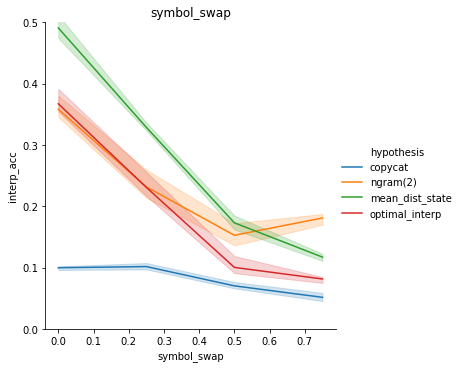

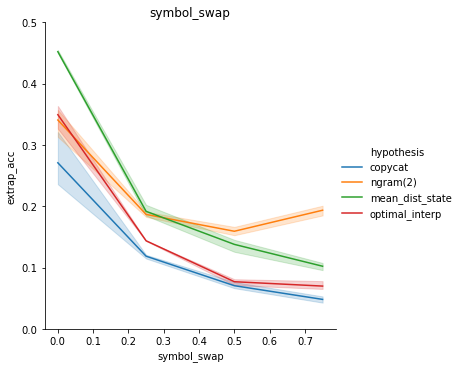

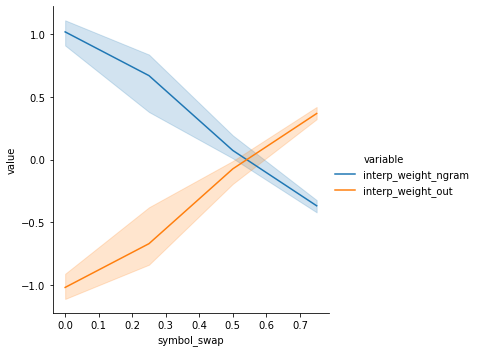

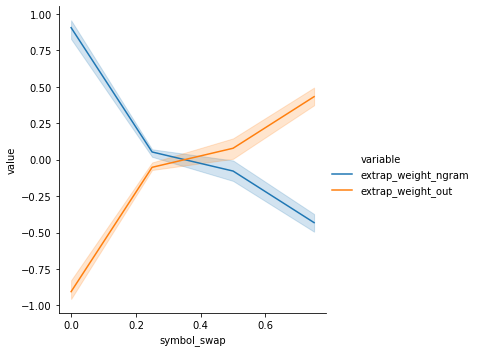

  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1699 epochs with tolerance 1.0048537153678427
finished training after 1699 epochs with tolerance 1.0043509886503719


 33%|███▎      | 1/3 [01:47<03:35, 107.69s/it]

finished training after 1999 epochs with tolerance 1.0106242283957299
finished training after 1999 epochs with tolerance 1.0105998743710543


 67%|██████▋   | 2/3 [03:56<01:53, 113.92s/it]

finished training after 1999 epochs with tolerance 1.0073534722661066
finished training after 1999 epochs with tolerance 1.0099365185429616


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.0987253206290903
finished training after 1999 epochs with tolerance 1.099345274765141


 33%|███▎      | 1/3 [02:11<04:22, 131.15s/it]

finished training after 1999 epochs with tolerance 1.113312653196166
finished training after 1999 epochs with tolerance 1.1118545145657017


 67%|██████▋   | 2/3 [04:24<02:11, 131.82s/it]

finished training after 1999 epochs with tolerance 1.1065955563345025
finished training after 1999 epochs with tolerance 1.1082519820634553


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.1665074812217469
finished training after 1999 epochs with tolerance 1.1659778161610044


 33%|███▎      | 1/3 [02:09<04:18, 129.48s/it]

finished training after 1999 epochs with tolerance 1.1760485555097242
finished training after 1999 epochs with tolerance 1.1745619915443886


 67%|██████▋   | 2/3 [04:22<02:10, 130.51s/it]

finished training after 1999 epochs with tolerance 1.1699713417588582
finished training after 1999 epochs with tolerance 1.169879526850084


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.2011347969606594
finished training after 1999 epochs with tolerance 1.2013373511054801


 33%|███▎      | 1/3 [02:08<04:16, 128.21s/it]

finished training after 1999 epochs with tolerance 1.2079970624502414
finished training after 1999 epochs with tolerance 1.2079327877781236


 67%|██████▋   | 2/3 [04:15<02:07, 127.96s/it]

finished training after 1999 epochs with tolerance 1.2015191366153748
finished training after 1999 epochs with tolerance 1.2015872909838992


100%|██████████| 3/3 [06:33<00:00, 131.24s/it]


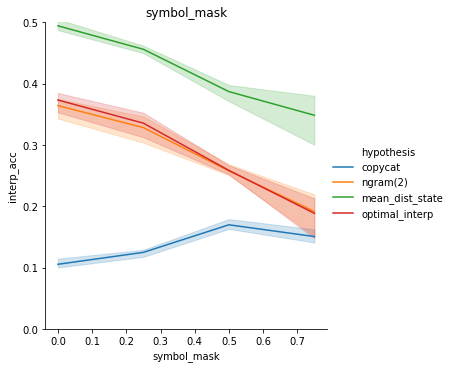

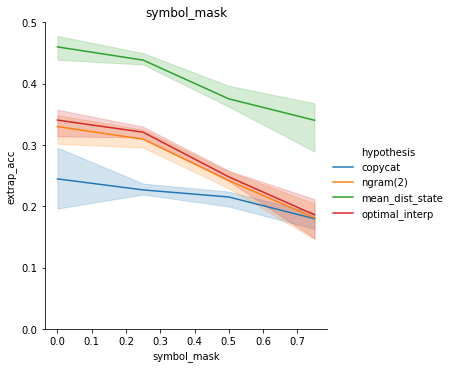

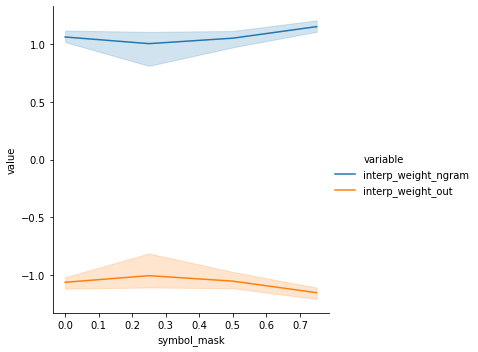

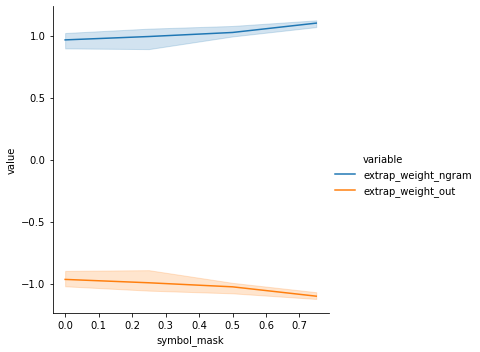

  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1699 epochs with tolerance 1.0039912842606125
finished training after 1899 epochs with tolerance 1.0024497377176902


 33%|███▎      | 1/3 [01:55<03:51, 115.59s/it]

finished training after 1999 epochs with tolerance 1.0124550490263036
finished training after 1999 epochs with tolerance 1.0107230997603078


 67%|██████▋   | 2/3 [04:09<02:01, 121.18s/it]

finished training after 1999 epochs with tolerance 1.0084074092586974
finished training after 1999 epochs with tolerance 1.008103652540132


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.0214899427944186
finished training after 1999 epochs with tolerance 1.024526349817608


 33%|███▎      | 1/3 [02:13<04:27, 133.56s/it]

finished training after 1999 epochs with tolerance 1.0400820027156763
finished training after 1999 epochs with tolerance 1.0370595202370079


 67%|██████▋   | 2/3 [04:24<02:12, 132.78s/it]

finished training after 1999 epochs with tolerance 1.031571449696137
finished training after 1999 epochs with tolerance 1.0323858004442759


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.042110364374385
finished training after 1999 epochs with tolerance 1.0400932086843175


 33%|███▎      | 1/3 [02:07<04:15, 127.65s/it]

finished training after 1999 epochs with tolerance 1.061030145458884
finished training after 1999 epochs with tolerance 1.0621620340855897


 67%|██████▋   | 2/3 [04:20<02:09, 129.23s/it]

finished training after 1999 epochs with tolerance 1.0580897825021789
finished training after 1999 epochs with tolerance 1.058051723139592


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.0623902519660602
finished training after 1999 epochs with tolerance 1.0694775014801434


 33%|███▎      | 1/3 [01:56<03:52, 116.31s/it]

finished training after 1999 epochs with tolerance 1.088127967910171
finished training after 1999 epochs with tolerance 1.0870131853113731


 67%|██████▋   | 2/3 [03:58<01:58, 118.06s/it]

finished training after 1999 epochs with tolerance 1.0941391849833078
finished training after 1999 epochs with tolerance 1.0799536798995641


100%|██████████| 3/3 [06:03<00:00, 121.21s/it]


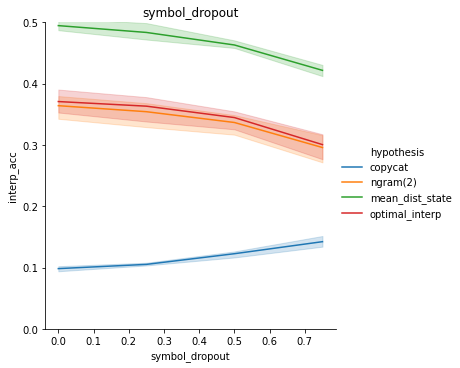

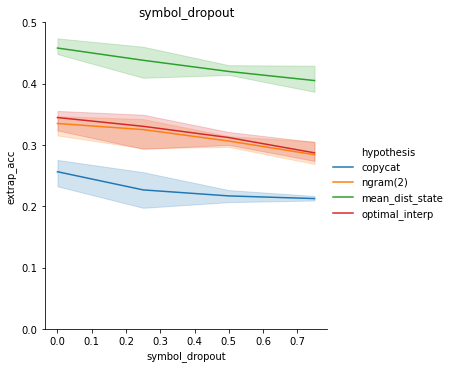

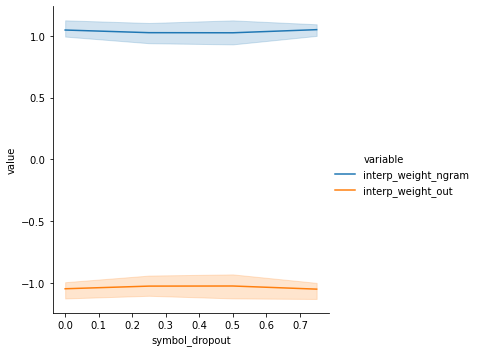

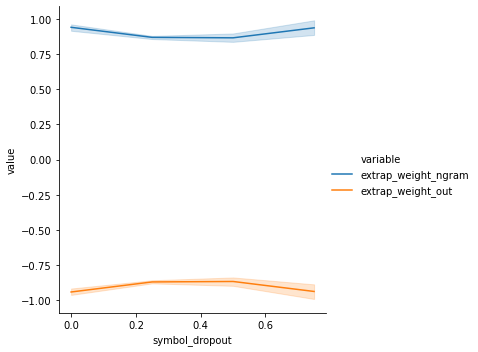

  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1699 epochs with tolerance 1.0040265661402656
finished training after 1699 epochs with tolerance 1.004963229129737


 33%|███▎      | 1/3 [01:42<03:24, 102.22s/it]

finished training after 1999 epochs with tolerance 1.0108604974644921
finished training after 1999 epochs with tolerance 1.0103758286770825


 67%|██████▋   | 2/3 [03:43<01:47, 107.93s/it]

finished training after 1999 epochs with tolerance 1.0084556698964622
finished training after 1999 epochs with tolerance 1.0085796236699909


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.0630779366952887
finished training after 1999 epochs with tolerance 1.064613162037871


 33%|███▎      | 1/3 [02:00<04:01, 120.58s/it]

finished training after 1999 epochs with tolerance 1.0822717857087296
finished training after 1999 epochs with tolerance 1.07888634360799


 67%|██████▋   | 2/3 [04:01<02:00, 120.69s/it]

finished training after 1999 epochs with tolerance 1.0756789732092658
finished training after 1999 epochs with tolerance 1.0785894847953537


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.1040221271985187
finished training after 1999 epochs with tolerance 1.1018948675036138


 33%|███▎      | 1/3 [02:02<04:04, 122.14s/it]

finished training after 1999 epochs with tolerance 1.126627177754482
finished training after 1999 epochs with tolerance 1.1260701852580324


 67%|██████▋   | 2/3 [04:07<02:03, 123.14s/it]

finished training after 1999 epochs with tolerance 1.1176269385072235
finished training after 1999 epochs with tolerance 1.1181834078145654


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.1262254390391733
finished training after 1999 epochs with tolerance 1.126411243209428


 33%|███▎      | 1/3 [02:03<04:07, 123.63s/it]

finished training after 1999 epochs with tolerance 1.1473910795450284
finished training after 1999 epochs with tolerance 1.148472520671844


 67%|██████▋   | 2/3 [04:09<02:04, 124.29s/it]

finished training after 1999 epochs with tolerance 1.139601943913928
finished training after 1999 epochs with tolerance 1.1395196018016855


100%|██████████| 3/3 [06:17<00:00, 125.97s/it]


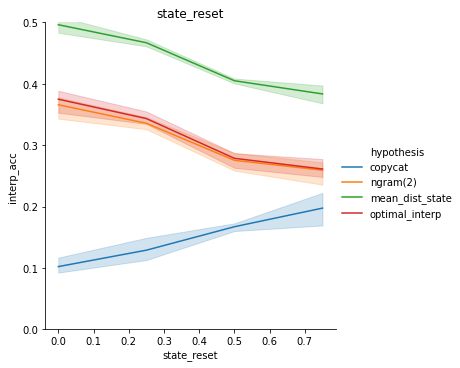

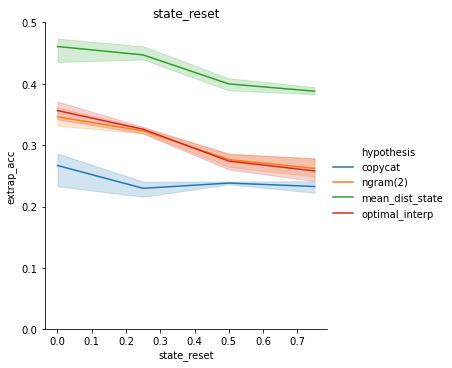

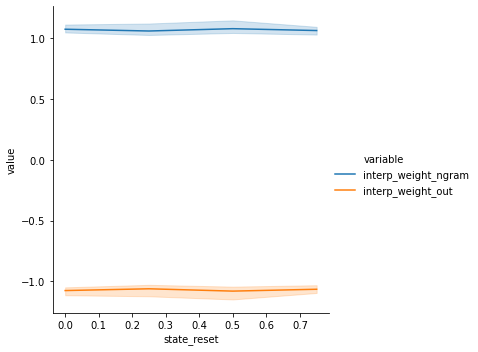

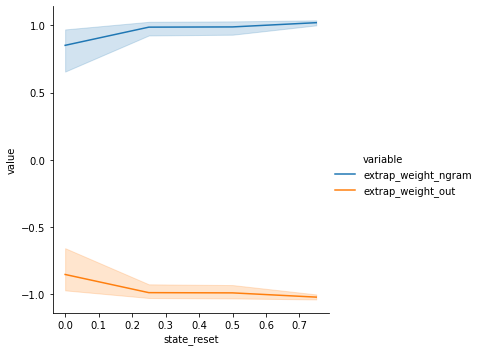

  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1699 epochs with tolerance 1.0044129374477095
finished training after 1699 epochs with tolerance 1.0042349951411278


 33%|███▎      | 1/3 [01:44<03:29, 104.85s/it]

finished training after 1999 epochs with tolerance 1.0115782122716395
finished training after 1999 epochs with tolerance 1.0104859704104794


 67%|██████▋   | 2/3 [03:48<01:50, 110.58s/it]

finished training after 1999 epochs with tolerance 1.009119836491546
finished training after 1999 epochs with tolerance 1.008734237041859


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.059425897665398
finished training after 1999 epochs with tolerance 1.0605337026734079


 33%|███▎      | 1/3 [02:01<04:03, 121.82s/it]

finished training after 1999 epochs with tolerance 1.0785143922457923
finished training after 1999 epochs with tolerance 1.0768834882282667


 67%|██████▋   | 2/3 [04:06<02:02, 122.62s/it]

finished training after 1999 epochs with tolerance 1.0747496884373393
finished training after 1999 epochs with tolerance 1.0750354159529407


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.1018178756970693
finished training after 1999 epochs with tolerance 1.1020903318397648


 33%|███▎      | 1/3 [02:03<04:06, 123.47s/it]

finished training after 1999 epochs with tolerance 1.1207328306688527
finished training after 1999 epochs with tolerance 1.1246155564369482


 67%|██████▋   | 2/3 [04:07<02:03, 123.59s/it]

finished training after 1999 epochs with tolerance 1.1171921397205506
finished training after 1999 epochs with tolerance 1.1163941733066303


  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1999 epochs with tolerance 1.1306957943325342
finished training after 1999 epochs with tolerance 1.130897942631477


 33%|███▎      | 1/3 [02:05<04:11, 125.89s/it]

finished training after 1999 epochs with tolerance 1.1530187300559203
finished training after 1999 epochs with tolerance 1.154117624070475


 67%|██████▋   | 2/3 [04:08<02:05, 125.06s/it]

finished training after 1999 epochs with tolerance 1.143748055675223
finished training after 1999 epochs with tolerance 1.143791141454665


100%|██████████| 3/3 [06:16<00:00, 125.50s/it]


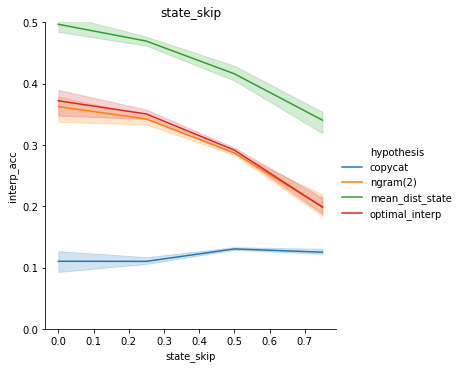

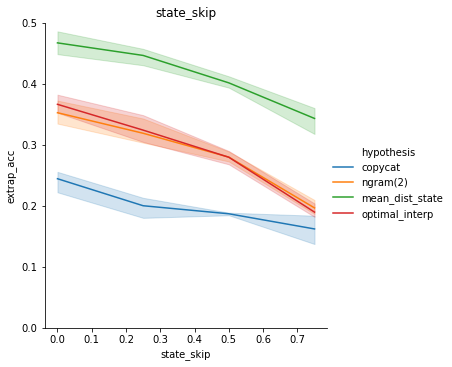

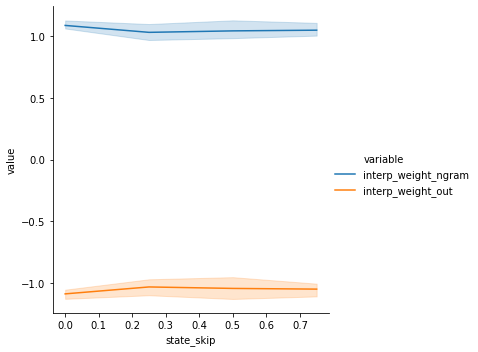

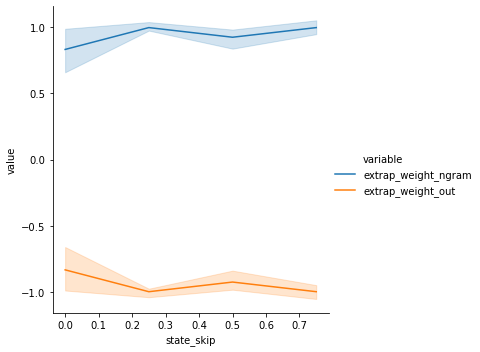

  0%|          | 0/3 [00:00<?, ?it/s]

finished training after 1699 epochs with tolerance 1.0041502224677523
finished training after 1799 epochs with tolerance 1.0023013023882696


 33%|███▎      | 1/3 [01:42<03:24, 102.22s/it]

finished training after 1999 epochs with tolerance 1.012055809926453
finished training after 1999 epochs with tolerance 1.0100610173206748


 67%|██████▋   | 2/3 [03:44<01:48, 108.32s/it]

In [ ]:
results1 = []

configs = [
    {"symbol_swap": [0, 1/4, 1/2, 3/4]},
    {"symbol_mask": [0, 1/4, 1/2, 3/4]},
    {"symbol_dropout": [0, 1/4, 1/2, 3/4]},
    {"state_reset": [0, 1/4, 1/2, 3/4]},
    {"state_skip": [0, 1/4, 1/2, 3/4]},
    {"state_dropout": [0, 1/4, 1/2, 3/4]}
]

for config in configs:
    assert len(config) == 1
    noise_type, = config.keys()
    noise_values = config[noise_type]
    result_group = []
    for noise_value in noise_values:
        dfa_rand = np.random.RandomState(0)
        for i in tqdm(range(3)):
            dfa = Dfa.generate_balanced(dfa_rand, N_STATES, N_SYMBOLS, N_ADJACENCIES)
            #display(dfa.render())
            hypotheses = [
                #("unif             ", unif_hyp),
                ("copycat          ", copycat_hyp),
                ("ngram(2)         ", ngram_hyp(2)),
                #("mean_out_state   ", mean_out_state_hyp),
                ("mean_dist_state  ", mean_dist_state_hyp),
                #("both_state       ", mean_both_state_hyp),
            ]
            data_rand = np.random.RandomState(0)
            result_group += run_experiment_1(
                dfa,
                data_rand,
                hypotheses,
                **{noise_type: noise_value}
            )

    results1.append(result_group)
    result_group = pd.DataFrame(result_group)
    
    sns.relplot(data=result_group, hue="hypothesis", x=noise_type, y="interp_acc", aspect=1, kind="line")
    plt.title(noise_type)
    plt.ylim(0, 0.5)
    plt.show()
    
    sns.relplot(data=result_group, hue="hypothesis", x=noise_type, y="extrap_acc", aspect=1, kind="line")
    plt.title(noise_type)
    plt.ylim(0, 0.5)
    plt.show()
    
    sns.relplot(
        data=result_group.melt(id_vars=[noise_type], value_vars=["interp_weight_ngram", "interp_weight_out"]),
        x=noise_type, y="value", hue="variable", aspect=1, kind="line"
    )
    plt.show()
    
    sns.relplot(
        data=result_group.melt(id_vars=[noise_type], value_vars=["extrap_weight_ngram", "extrap_weight_out"]),
        x=noise_type, y="value", hue="variable", aspect=1, kind="line"
    )
    plt.show()

In [ ]:
result_group